## Abstract embeddings

In [1]:
import numpy as np
import pickle
import json
from typing import List
from dataclasses import dataclass

@dataclass
class Document:
    id: str
    abstract: str
    conclusions: str
    arxiv_id: str
    title: str = None
    score: float = None
    n_citation: int = None
    keywords: List[str] = None

# Load the full embeddings matrix
embeddings = np.load('../data/vector_store/embeddings_matrix.npy')

# Load the index mapping
with open('../data/vector_store/index_mapping.pkl', 'rb') as f:
    index_mapping = pickle.load(f)

# Load the documents
with open('../data/vector_store/documents.pkl', 'rb') as f:
    documents = pickle.load(f)

# Create lists to store the abstract embeddings and corresponding text
abstract_embeddings = []
abstract_texts = []
doc_ids = []

# Iterate through the index mapping to find abstract indices and corresponding text
for doc_id, mappings in index_mapping.items():
    if 'abstract' in mappings:
        abstract_index = mappings['abstract']
        abstract_embeddings.append(embeddings[abstract_index])
        
        # Find the corresponding document and extract the abstract text
        doc = next((d for d in documents if d.id == doc_id), None)
        if doc:
            abstract_texts.append(doc.abstract)
            doc_ids.append(doc_id)
        else:
            print(f"Warning: Document with ID {doc_id} not found.")

# Convert lists to numpy arrays
abstract_embeddings = np.array(abstract_embeddings)

print(f"Processed {len(abstract_embeddings)} abstract embeddings.")
print(f"Shape of abstract embeddings: {abstract_embeddings.shape}")
print(f"Length of abstract texts: {len(abstract_texts)}")
print(f"Length of document IDs: {len(doc_ids)}")

# Save the abstract embeddings
np.save('../data/vector_store/abstract_embeddings.npy', abstract_embeddings)

# Save the abstract texts and document IDs
with open('../data/vector_store/abstract_texts.json', 'w') as f:
    json.dump({
        'doc_ids': doc_ids,
        'abstracts': abstract_texts
    }, f)

print("Saved abstract embeddings and texts.")

KeyboardInterrupt: 

## Top-k values and indices

In [34]:
import torch
import numpy as np
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset
from saerch.topk_sae import FastAutoencoder  # Assuming train.py contains your FastAutoencoder class

# Set grad to false
torch.set_grad_enabled(False)

# Hyperparameters (Make sure these match your training configuration)
n_dirs = 32768
d_model = 1536
k = 32
auxk = 256
batch_size = 1024

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained model
ae = FastAutoencoder(n_dirs, d_model, k, auxk).to(device)
model_path = 'checkpoints/sae_model_epoch_10.pth'
ae.load_state_dict(torch.load(model_path))
ae.eval()

# Load abstract embeddings
abstract_embeddings = np.load("../data/vector_store/abstract_embeddings.npy")
abstract_embeddings = abstract_embeddings.astype(np.float32)

# Create a DataLoader for efficient batching
dataset = TensorDataset(torch.from_numpy(abstract_embeddings))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Prepare arrays to store results
num_abstracts = len(abstract_embeddings)
topk_indices = np.zeros((num_abstracts, k), dtype=np.int64)
topk_values = np.zeros((num_abstracts, k), dtype=np.float32)

# Process batches
with torch.no_grad():
    for i, (batch,) in enumerate(tqdm(dataloader, desc="Processing abstracts")):
        batch = batch.to(device)
        _, info = ae(batch)
        
        start_idx = i * batch_size
        end_idx = start_idx + batch.size(0)
        
        topk_indices[start_idx:end_idx] = info['topk_indices'].cpu().numpy()
        topk_values[start_idx:end_idx] = info['topk_values'].cpu().numpy()

# Create directory to save results
os.makedirs("sae_data", exist_ok=True)

# Save results
np.save("sae_data/topk_indices.npy", topk_indices)
np.save("sae_data/topk_values.npy", topk_values)

print("Processing complete. Results saved in 'sae_data' folder.")

Processing abstracts: 100%|██████████| 266/266 [00:42<00:00,  6.25it/s]

Processing complete. Results saved in 'sae_data' folder.


In [2]:
import numpy as np

# Load them
topk_indices = np.load("sae_data/topk_indices.npy")
topk_values = np.load("sae_data/topk_values.npy")

In [3]:
topk_indices.shape

(271540, 32)

[0.00000000e+00 0.00000000e+00 1.16005008e-03 ... 0.00000000e+00
 9.57501657e-05 3.68269868e-06]
Num features:  32766
Number of non-zero feature densities: 10869


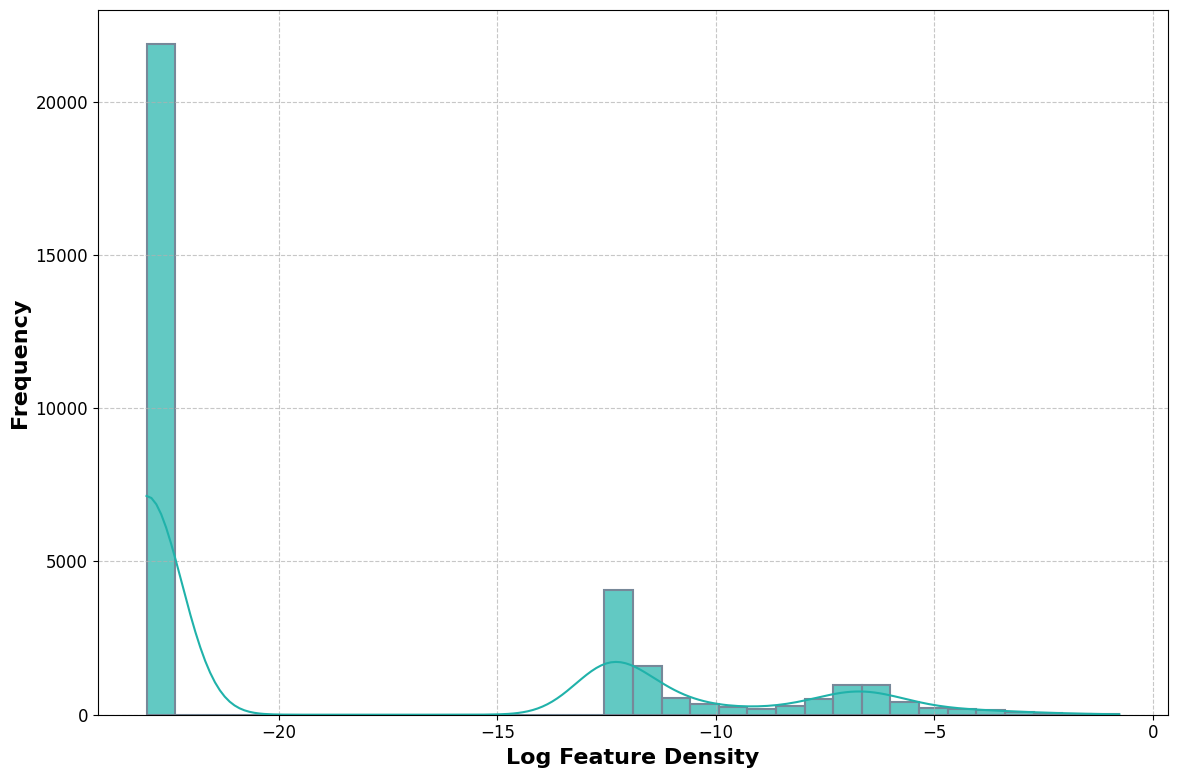

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

def plot_log_feature_density(topk_indices, save_path=None, dpi=300):
    """
    Create a publication-quality log feature density plot.
    
    :param topk_indices: numpy array of shape (num_samples, k) containing the indices of top-k features
    :param save_path: path to save the figure (if None, the figure will be displayed)
    :param dpi: resolution of the output figure
    """
    # Calculate feature density
    num_samples, k = topk_indices.shape
    num_features = topk_indices.max() + 1
    feature_counts = np.bincount(topk_indices.flatten(), minlength=num_features)
    feature_density = feature_counts / num_samples

    print(feature_density)
    print("Num features: ", num_features)
    # Print non-zero feature density
    print(f"Number of non-zero feature densities: {np.count_nonzero(feature_density)}")
    
    # Calculate log feature density
    log_feature_density = np.log(feature_density + 1e-10)  # Add small constant to avoid log(0)
    
    # Set up the plot style
    #plt.style.use('seaborn-whitegrid')
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    
    # Create custom colormap
    colors = ['#FFA07A', '#20B2AA', '#778899']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the histogram
    sns.histplot(log_feature_density, kde=True, color=colors[1], 
                 edgecolor=colors[2], linewidth=1.5, alpha=0.7, ax=ax)
    
    # Customize the plot
    ax.set_xlabel('Log Feature Density', fontweight='bold')
    ax.set_ylabel('Frequency', fontweight='bold')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Improve layout
    plt.tight_layout()
    
    # Save or display the plot
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    else:
        plt.show()
    
    plt.close()

# Plot the log feature density
plot_log_feature_density(topk_indices)